## \[Data Science\] Full stack training

- campo chave para junção das tabelas: `grower_document`
- tabela base: `md_grower_report`
  - corresponde ao cadastro de agricultores da Bayer

In [51]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from math import isnan
from pathlib import Path

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
INPUT_FOLDER = Path.cwd().parent / "inputs"

In [4]:
csv_files = Path(INPUT_FOLDER).glob('**/*.csv')

In [5]:
df = {f"{csv_file.name[10:-4]}": pd.read_csv(csv_file) for csv_file in csv_files}

/var/folders/g0/342sbsdd56173k7xyxgl_jh1w0chb5/T/ipykernel_2475/670898405.py:1: DtypeWarning: Columns (38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = {f"{csv_file.name[10:-4]}": pd.read_csv(csv_file) for csv_file in csv_files}
/var/folders/g0/342sbsdd56173k7xyxgl_jh1w0chb5/T/ipykernel_2475/670898405.py:1: DtypeWarning: Columns (1,2,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df = {f"{csv_file.name[10:-4]}": pd.read_csv(csv_file) for csv_file in csv_files}
/var/folders/g0/342sbsdd56173k7xyxgl_jh1w0chb5/T/ipykernel_2475/670898405.py:1: DtypeWarning: Columns (37,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = {f"{csv_file.name[10:-4]}": pd.read_csv(csv_file) for csv_file in csv_files}


In [6]:
df.keys()

dict_keys(['sales', 'disque_intacta', 'md_grower_report', 'saved_seeds', 'entered_area'])

## Tables:

- **sales** => (871.264, 79) - (a_seller_document, **a_buyer_document**)
- **disque_intacta** => (385.716, 51)
- **md_grower_report** => (514.182, 38) - (a_grower_document)
- **saved_seeds** => (19.648, 72)
- **entered_area** => (51.262, 40)

### Filters
- Growers who purchased at least once in the last 24 months from T0
- Growers who purchased for the first time in the last 6 months from T0 must be classified as NEW in a separate segment

## Dealing with duplicated data

An initial `left outer join` between `sales` and `md_grower_report` was resulting an amount greater than the number of rows of `sales`

This raised a red flag because probably there were duplicated keys in `md_grower_report`

Then, I started investigating

In [7]:
df_dup_detected = pd.merge(
    df["sales"],
    df["md_grower_report"],
    how="left",
    # on=None,
    left_on=["a_buyer_document"],
    right_on=["a_grower_document"],
    # left_index=False,
    # right_index=False,
    # sort=True,
    suffixes=("_seller", "_grower"),
)
df_dup_detected.shape

(882551, 117)

`896.150` **>** `871.264` :: `24.886` extra amount (**!!!**)

In [8]:
grower_docs = df["md_grower_report"]["a_grower_document"]
grower_docs_unq = df["md_grower_report"]["a_grower_document"].unique()
print(f"Comparing grower_docs.size with grower_docs_unq.size => {len(grower_docs)} vs {len(grower_docs_unq)}")
assert len(df["md_grower_report"]["a_grower_document"]) == len(df["md_grower_report"]["a_grower_document"].unique())

Comparing grower_docs.size with grower_docs_unq.size => 514182 vs 461935


AssertionError: 

In [9]:
df["md_grower_report"].dropna(subset=["a_grower_document"]).shape

(475945, 38)

In [10]:
# droping empty keys
df["md_grower_report"] = df["md_grower_report"].dropna(subset=["a_grower_document"])

In [11]:
ids = df["md_grower_report"]["a_grower_document"]
df_grower_report_dup = df["md_grower_report"][ids.isin(ids[ids.duplicated()])].sort_values("a_grower_document")
df_grower_report_dup.shape

(28011, 38)

In [12]:
# droping duplicated keys
df["md_grower_report"] = df["md_grower_report"].drop_duplicates(subset=["a_grower_document"], keep='first')
df["md_grower_report"].shape

(461934, 38)

In [13]:
df_cleaned = pd.merge(
    df["sales"],
    df["md_grower_report"],
    how="left",
    # on=None,
    left_on=["a_buyer_document"],
    right_on=["a_grower_document"],
    # left_index=False,
    # right_index=False,
    # sort=True,
    suffixes=("_seller", "_grower"),
)
df_cleaned.shape

(871264, 117)

`871.264` **=** `871.264` :: **ZERO** extra amount (*first mission accomplished*)

In [14]:
# df_final = pd.merge(
#     df_cleaned,
#     df["md_grower_report"],
#     how="left",
#     # on=None,
#     left_on=["a_buyer_document"],
#     right_on=["a_grower_document"],
#     # left_index=False,
#     # right_index=False,
#     # sort=True,
#     suffixes=("_buyer", "_grower_2"),
# )
# df_final.shape

`871.264` **=** `871.264` :: **ZERO** extra amount (*double check done*)

notice that the number of column are equal to `79` **+** `38` **+** `38` (**=** `155`)

number of columns in `sales` = 79 / number of columns in `md_grower_report` = 38

## Analyzing columns

It would be interesting to have some metrics related to each column of each table available

These metrics would help to filter candidates to be used as features in our clustering model

Some suggested metrics:
- number_of_values (`done`)
- entropy
- uniqueness_rate (`done`)
- count_unique_values (`done`)
- numerical_values_rate (`done`)
- alphabetical_values_rate (`done`)
- mean_numerical_values
- mean_alphabetical_values
- std_numerical_chars_in_values
- std_alphabetical_chars_in_values
- mean_special_chars_in_values
- mean_words_in_values
- std_special_chars_in_values
- std_words_in_values
- percent_none_values (`done`)
- count_none_values (`done`)
- min_value
- max_value
- median_value
- mode_value (`done`)

In [15]:
def number_of_values(series):
    return len(series)

In [16]:
def uniqueness_rate(series):
    return len(series.unique()) / len(series)

In [17]:
def count_unique_values(series):
    return len(series.unique())

In [18]:
def numerical_values_rate(series):
    return sum([1 if str(val).isnumeric() else 0 for val in series]) / len(series)

In [19]:
def percent_none_values(series):
    sum = 0
    for val in series:
        try:
            if not str(val):  # checking falsy values
                sum += 1
            elif str(val).isalpha() and isnan(float(val)):  # checking nan values
                sum += 1
        except ValueError:
            continue
    return sum / len(series)

In [20]:
def count_none_values(series):
    sum = 0
    for val in series:
        try:
            if not str(val):  # checking falsy values
                sum += 1
            elif str(val).isalpha() and isnan(float(val)):  # checking nan values
                sum += 1
        except ValueError:
            continue
    return sum

In [21]:
def mode_value(series):
    aux = {}
    for val in series:
        aux[val] = aux.get(val, 0) + 1
    max_key, max_val = (0, 0)
    for k, v in aux.items():
        if v > max_val:
            max_key = k
            max_val = v
    return max_key, max_val

In [22]:
df["md_grower_report"].columns

Index(['Unnamed: 0', 'id', 'grower_document_type', 'a_grower_document',
       'a_grower_name', 'a_grower_fantasy_name', 'a_email', 'collaborator',
       'cooperative', 'groundbreaker', 'precertificate', 'precertificate_from',
       'precertificate_to', 'a_address', 'address_type', 'additional_info',
       'neighborhood', 'state_id', 'state', 'city', 'city_id', 'region',
       'district', 'agreement_id', 'agreement_template_id', 'technology',
       'agreement_type', 'status', 'bid', 'creation_user', 'creation_date',
       'sent_user', 'sent_date', 'approval_user', 'approval_date', 'comments',
       'region_grower', 'district_grower'],
      dtype='object')

In [23]:
metrics = [
    "number_of_values",
    "uniqueness_rate",
    "count_unique_values",
    "numerical_values_rate",
    "percent_none_values",
    "count_none_values",
    "mode_value",
]

In [24]:
def analysis_per_column(dff, column):
    return {metric: globals()[metric](dff[column]) for metric in metrics}

In [25]:
analysis_per_column(df["md_grower_report"], "state")

{'number_of_values': 461934,
 'uniqueness_rate': 6.061471985175371e-05,
 'count_unique_values': 28,
 'numerical_values_rate': 0.0,
 'percent_none_values': 2.38129256560461e-05,
 'count_none_values': 11,
 'mode_value': ('Paraná', 162682)}

In [26]:
df_cleaned.shape

(871264, 117)

In [27]:
df_cleaned.head()

,Unnamed: 0_seller,sale_id,sale_item_id,sale_type,invoice_number,invoice_date,harvest_name,operational_year_name,plantation_city_name,plantation_state_name,seller_unit,seller_region,seller_district,buyer_unit,buyer_region,buyer_district,multiplier_unit,multiplier_region,multiplier_district,product_name,technology_name,company_name,crop_name,brand_name,total_discounts,sales_origin,due_dates,creation_date_seller,sale_item_status,sap_sale_order,sap_document_number,billing_date,payment_date,revenue_recognition_date,multiplier_document_type,wts_range,batch,buyer_city,buyer_groundbreaker,buyer_state,buyer_precertificate,planting_region,region_of_city_planting,district_of_city_planting,user_registration,user_cancellation,user_edition,validated_by,validation_date,payment_method,head_office_city,partner_city,head_office_contracts,head_office_district,head_office_region,head_office_uf,partner_uf,head_office_unit,sale_adjustment_user,sale_adjustment_date,is_sale_adjustment,unit_of_city_planting,load_date,creation_date_partition,a_qty,a_kg_ha,a_unit_net_price,a_productivity,a_sold_qty_bags,a_sold_qty_ha,a_total_net_price,a_credit_volume,a_seller_name,a_buyer_name,a_multiplier_name,a_head_office_name,a_seller_document,a_buyer_document,a_multiplier_document_fmt,Unnamed: 0_grower,id,grower_document_type,a_grower_document,a_grower_name,a_grower_fantasy_name,a_email,collaborator,cooperative,groundbreaker,precertificate,precertificate_from,precertificate_to,a_address,address_type,additional_info,neighborhood,state_id,state,city,city_id,region,district,agreement_id,agreement_template_id,technology,agreement_type,status,bid,creation_user,creation_date_grower,sent_user,sent_date,approval_user,approval_date,comments,region_grower,district_grower
0,0,7d740463-6ff1-4626-bfb5-ecab1eb24397,039694b4-d7ee-4992-9a51-98a75809324c,Distribuidor para Agricultor,308760.0,2018-11-19,SAFRA 18/19,2018.0,SEARA,SANTA CATARINA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,BS 1511 IPRO,INTACTA,MONSANTO,SOJA,BAYER,NaN,EXCEL,NaN,2019-05-28 17:01:12.975,REGISTERED,NaN,NaN,NaN,2018-12-13 10:00:22.741,NaN,CNPJ,DE 225 A 230,329/2018,SEARA,False,SANTA CATARINA,False,SANTA CATARINA,SUL LESTE SOJA,CHAPECO-SOJA,PMALT,NaN,NaN,NaN,NaN,NaN,CONCÓRDIA,CONCÓRDIA,NaN,CHAPECO-SOJA,SUL LESTE SOJA,SC,SC,SUL LESTE SOJA/ICS,PMALT,2019-05-28 14:01:12.975-03,True,SUL LESTE SOJA/ICS,2022-05-18,2019-05,11.969670,0.058216,NaN,NaN,11.969670,12.280524,NaN,NaN,seller_name0,buyer_name0,multiplier_name0,head_office_name0,197737,652567,526791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,d25fd8ef-f120-45fb-889e-e2bedfa0373c,6ddbbf03-e12a-4314-a40c-43fb8f4b6d78,Distribuidor para Agricultor,100768.0,2018-10-30,SAFRA 18/19,2018.0,PASSOS MAIA,SANTA CATARINA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-SOJA,NS 5445 IPRO,INTACTA,MONSANTO,SOJA,NIDERA,NaN,EXCEL,NaN,2019-05-29 14:03:26.091,REGISTERED,NaN,NaN,NaN,2018-12-13 10:00:22.741,NaN,CNPJ,DE 201 A 206,730EVRQ101,PASSOS MAIA,False,SANTA CATARINA,False,SANTA CATARINA,SUL LESTE SOJA,CHAPECO-SOJA,PMALT,NaN,NaN,NaN,NaN,NaN,CONCÓRDIA,CONCÓRDIA,NaN,CHAPECO-SOJA,SUL LESTE SOJA,SC,SC,SUL LESTE SOJA/ICS,PMALT,2019-05-29 11:03:26.091-03,True,SUL LESTE SOJA/ICS,2022-05-18,2019-05,11.832499,0.041659,NaN,NaN,11.832499,12.247604,NaN,NaN,seller_name0,buyer_name1,multiplier_name0,head_office_name0,197737,686993,526791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,d25fd8ef-f120-45fb-889e-e2bedfa0373c,a0a8d735-9b95-4e32-a5d9-9b2dad64320a,Distribuidor para Agricultor,100768.0,2018-10-30,SAFRA 18/19,2018.0,PASSOS MAIA,SANTA CATARINA,SUL LESTE SOJA/ICS,SUL LESTE SOJA,CHAPECO-

In [28]:
analysis_per_column(df_cleaned, "a_buyer_document")

{'number_of_values': 871264,
 'uniqueness_rate': 0.18058935064458076,
 'count_unique_values': 157341,
 'numerical_values_rate': 1.0,
 'percent_none_values': 0.0,
 'count_none_values': 0,
 'mode_value': (818151, 4507)}

## Reducing the dataframe - applying date filters

- assigning two variables
  - `year`: it will be used to filter growers who purchased in the last two years
  - `half_year`: it will be used to filter brand new growers who had their first purchased in the last 6 months

In [29]:
year = dt.timedelta(days=365)
half_year = dt.timedelta(days=365) // 2

In [30]:
df_filtered_date = df_cleaned[df_cleaned["invoice_date"] >= str(dt.date.today() - 2 * year)]

In [31]:
df_filtered_date.shape

(575894, 117)

Dataset reduced from `871.264` to `575.894`

Now we're going to perform some aggregations to find out:
- amount of purchases
- first purchase
- last purchase

In [48]:
dff = df_filtered_date.groupby("a_buyer_document") \
                      .agg(sales=pd.NamedAgg(column="sale_id", aggfunc="count"),
                           first_sale=pd.NamedAgg(column="invoice_date", aggfunc="min"),
                           last_sale=pd.NamedAgg(column="invoice_date", aggfunc="max")
                      )
dff.reset_index(inplace=True)
dff.sort_values(by=["sales"], ascending=False)

,a_buyer_document,sales,first_sale,last_sale
110642,818151,2971,2020-08-03,2022-01-31
64482,555065,1517,2020-07-15,2021-12-21
7694,143979,1342,2020-08-28,2022-02-23
61213,536706,1286,2020-09-18,2022-01-07
99152,753009,1092,2020-08-11,2021-12-07
...,...,...,...,...
65257,559555,1,2021-09-22,2021-09-22
65252,559520,1,2021-11-09,2021-11-09
65251,559511,1,2021-10-06,2021-10-06
65246,559476,1,2021-12-15,2021-12-15


Creating buckets based on amount of sales to understand better the distribution

In [57]:
conditions = [
    (dff["sales"] <= 500),
    (dff["sales"] > 500) & (dff["sales"] <= 1000),
    (dff["sales"] > 1000) & (dff["sales"] <= 1500),
    (dff["sales"] > 1500) & (dff["sales"] <= 2000),
    (dff["sales"] > 2000) & (dff["sales"] <= 2500),
    (dff["sales"] > 2500)
]
categories = ["0-500", "501-1000", "1001-1500", "1501-2000", "2001-2500", "2501+"]
dff["amount_sales_cat"] = np.select(conditions, categories)

In [58]:
dff.sort_values(by=["sales"], ascending=False)

,a_buyer_document,sales,first_sale,last_sale,amount_sales_cat
110642,818151,2971,2020-08-03,2022-01-31,2501+
64482,555065,1517,2020-07-15,2021-12-21,1501-2000
7694,143979,1342,2020-08-28,2022-02-23,1001-1500
61213,536706,1286,2020-09-18,2022-01-07,1001-1500
99152,753009,1092,2020-08-11,2021-12-07,1001-1500
...,...,...,...,...,...
65257,559555,1,2021-09-22,2021-09-22,0-500
65252,559520,1,2021-11-09,2021-11-09,0-500
65251,559511,1,2021-10-06,2021-10-06,0-500
65246,559476,1,2021-12-15,2021-12-15,0-500


In [61]:
dff.groupby("amount_sales_cat").agg(total=pd.NamedAgg(column="a_buyer_document", aggfunc="count"))

,total
amount_sales_cat,
0-500,135844
1001-1500,3
1501-2000,1
2501+,1
501-1000,20


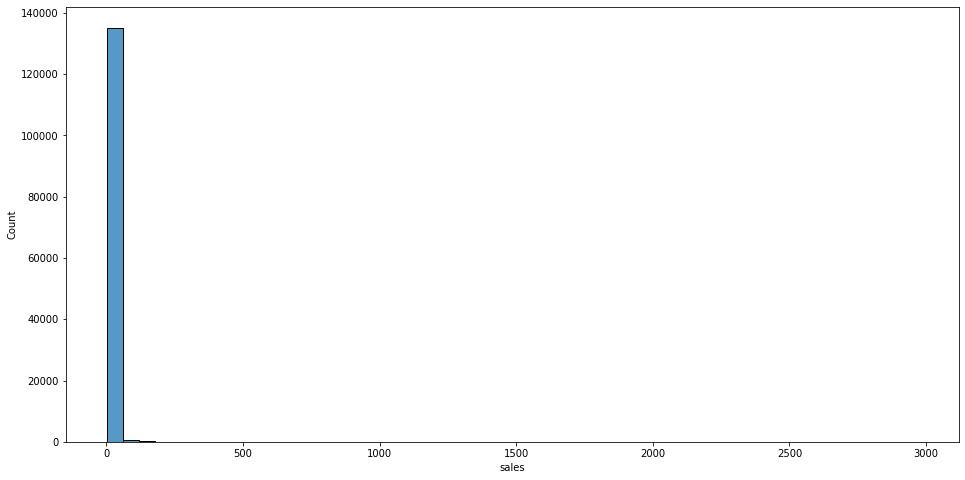

In [56]:
plt.figure(figsize=(16, 8))
sns.histplot(dff['sales'], bins=50)
plt.close(2)

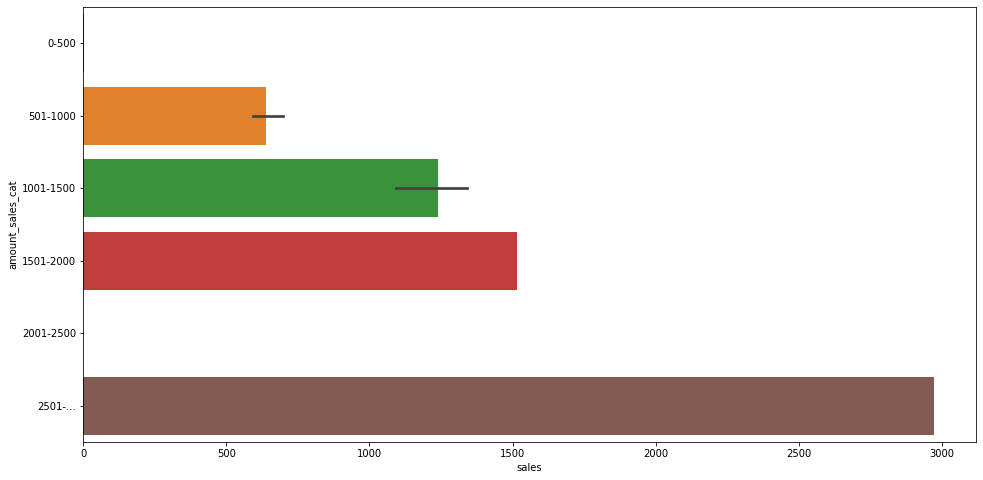

In [52]:
plt.figure(figsize=(16, 8))
sns.barplot(x="sales", y="amount_sales_cat", data=dff, order=categories)
plt.close(2)

In [38]:
dff[dff["first_sale"] > str(dt.date.today() - half_year)]

,a_buyer_document,sales,first_sale,last_sale
15,100111,1,2022-04-25,2022-04-25
37,100213,1,2022-01-19,2022-01-19
129,100705,1,2022-01-26,2022-01-26
203,101104,1,2022-03-24,2022-03-24
260,101455,2,2022-02-16,2022-02-16
...,...,...,...,...
135421,958957,1,2022-01-27,2022-01-27
135641,960246,1,2022-01-28,2022-01-28
135677,960455,2,2022-01-26,2022-01-26
135787,961079,1,2022-04-18,2022-04-18
